# <u><center>Prédire les récessions</center></u>

<center>Statistiques pour Big Data<center>

### Importation des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datapungi_fed as dpf
import numpy as np
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

### Importation de la base

In [106]:
df=pd.read_csv('current.csv',index_col=0)
df1=df.iloc[1:-1]
df1.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1/1/1959,2442.158,2293.2,17.272,292266.4261,18235.77392,22.0151,23.3984,22.2848,31.5847,18.6861,...,17.791,11.326,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2/1/1959,2451.778,2301.5,17.452,294424.7425,18369.56308,22.4463,23.7142,22.4778,31.8164,18.7842,...,17.798,11.343,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3/1/1959,2467.594,2318.5,17.617,293418.6704,18523.05762,22.7696,23.8577,22.5882,31.8164,19.1520,...,17.785,11.363,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4/1/1959,2483.671,2334.9,17.553,299322.8039,18534.46600,23.2547,24.2022,22.9191,32.3184,19.2746,...,17.796,11.403,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5/1/1959,2498.026,2350.4,17.765,301364.3249,18679.66354,23.6050,24.4032,23.1398,32.4728,19.6670,...,17.777,11.421,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


In [29]:
df1.shape   # 767 observations , 127 features

(767, 127)

### Traitement des valeurs manquantes 

In [534]:
s=df1.isnull().sum().sort_values()
nonzer=s.to_numpy().nonzero()
s.iloc[nonzer]

DTCTHFNM           1
DTCOLNVHFNM        1
BUSINVx            1
ISRATIOx           1
CONSPI             1
CP3Mx              1
HWI                1
HWIURATIO          1
S&P PE ratio       1
NONREVSL           1
CMRMTSPLx          1
COMPAPFFx          1
S&P div yield      2
PERMITW           12
PERMITS           12
PERMIT            12
PERMITNE          12
PERMITMW          12
VIXCLSx           42
ANDENOx          109
UMCSENTx         154
TWEXAFEGSMTHx    168
ACOGNO           398
dtype: int64

Les 4 dernières variables : ACOGNO (New orders for consumer goods),TWEXAFEGSMTHx (Trade weighted US dollar index), UMCSENTx
 (Consumer sentiment index), ANDENOx (New orders for Nondefense Capital Goods) seront supprimés car le taux des valeurs manquantes est assez élevé : > à 10%. La perte d'information par cette suppression n'est pas importante car les variables sont groupés dans des catégories (voir annexe) et chaque catégorie rassemble des variables semblables. 
 
Les variables présentant 12 et 42 NaNs feront l'objet d'une amputation par la moyenne.

Pour les autres variables, la ligne correspondante à un NaN sera supprimée (ce n'est pas des lignes différentes, donc on perdera pas trop d'informations).

Pour éviter le <b>data leakage</b>, nous procèderons au split train/test avant de faire l'amputation. Nous remplacerons les valeurs manquantes de l'échantillon d'entraînement par les moyennes calculés <u><b>sur l'échantillon d'entraînement et pas sur tout l'échantillon</b></u>, sinon on aurait utilisé une information out-of-sample pour construire notre modèle. 

In [108]:
 # supprimer les 2 dernières lignes (qui correspondent à des NaNs des 13 premières variables de la série s affichée ci-dessus)
df2=df1.drop(df1.tail(2).index)

In [109]:
# supprimer les colonnes des 4 dernières variables 
df3=df2.drop(['ANDENOx', 'UMCSENTx', 'TWEXAFEGSMTHx', 'ACOGNO'],axis=1)

In [121]:
df3.index=pd.to_datetime(df3.index)  # convertir les indices en datetime pour faciliter l'extraction des lignes après

### Split train/test

Vu qu'il s'agit d'une série temporelle , on ne va pas splitter la base aléatoirement. On fera le split manuellement, en prenant les 70% <u>premières</u> observations en train ( 535 observations ) et les 30% restants en test.

In [122]:
df_train=df3.iloc[:536]
df_test=df3.iloc[536:]

In [123]:
# remplacement par les moyennes ( chaque variable se voit attribué la moyenne de sa colonne , seulement sur la portion train )
df_train1=df_train.fillna(df_train.mean())

In [112]:
df_train1.isnull().sum().sort_values()   # on n'a plus de valeurs manquantes

RPI              0
T10YFFM          0
T5YFFM           0
T1YFFM           0
TB6SMFFM         0
                ..
USCONS           0
CES1021000001    0
USGOOD           0
CLAIMSx          0
VIXCLSx          0
Length: 123, dtype: int64

Vu qu'on travaille sur des séries temporelles, on doit stationnariser les variables. La 1ère ligne de la base de données (qu'on a supprimé dans le dataframe df1) comporte la transformation requise pour stationnariser ces variables : il s'agit de codes de 1 à 7 tel que chaque code représente une certaine transformation (ex : le code 5 correspond à une différence logarithmique). La signification des codes a été fournie dans un annexe à la base de données (voir annexe envoyé avec le rapport). 

Nous allons convertir cela en code; 

### Stationnarisation des données

In [97]:
# convertir les codes en leurs transformations d'après l'annexe 
def diff(serie):
    return (serie-serie.shift(1)).dropna()
def transf(serie,code):
    serie=serie.iloc[1:]
    s=serie    # initialiser la série
    if code==2:
        s=diff(serie)
    elif code==3:
        s=diff(diff(serie))
    elif code==4:
        s=np.log(serie)
    elif code==5:
        s=diff(np.log(serie))
    elif code==6:
        s=diff(diff(np.log(serie)))
    elif code==7:
        s=diff(serie.pct_change())
    return s

In [301]:
# parcourir les variables par une boucle for pour transformer chacune
lst=[]
lst_codes=(df.drop(['ANDENOx', 'UMCSENTx', 'TWEXAFEGSMTHx', 'ACOGNO'],axis=1)).iloc[0]
for i,code in enumerate(lst_codes):
    lst.append(transf(df_train1[df_train1.columns[i]],code))   

new_lst=[col['1959-04-01':] for col in lst]   # vu qu'il ya des doubles différenciations , il y a des variables pour lesquelles
                                             # les 2 premières lignes seront des NaNs

In [299]:
def stationnariser(df,lst_codes):
    lst=[]
    for i,code in enumerate(lst_codes):
        lst.append(transf(df_train1[df.columns[i]],code))   
    new_lst=[col[col.index[2]:]for col in lst]
    return pd.concat(new_lst,axis=1)

In [302]:
features_final=pd.concat(new_lst,axis=1)
features_final

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-04-01,0.006494,0.007049,-0.003639,0.019922,0.000616,0.021081,0.014337,0.014543,0.015655,0.006381,...,-0.000229,0.001349,0.001752,-0.000022,0.012203,-0.004890,0.012134,0.006734,0.024929,19.482232
1959-05-01,0.005763,0.006616,0.012005,0.006797,0.007803,0.014951,0.008271,0.009583,0.004766,0.020154,...,0.000646,-0.001687,-0.001937,-0.000021,-0.004090,-0.004819,0.002828,0.002020,-0.015342,19.482232
1959-06-01,0.003102,0.002974,0.003708,-0.000052,0.009064,0.001139,0.007036,0.007122,-0.004766,0.007452,...,0.000329,0.003316,0.002093,-0.004619,0.003992,0.004796,0.009726,0.009007,-0.012252,19.482232
1959-07-01,-0.000589,-0.000764,-0.003427,0.012110,-0.000330,-0.024238,0.001167,0.008252,0.013056,0.019606,...,-0.001521,-0.001238,-0.000100,0.000000,-0.004040,-0.004796,-0.004631,-0.001000,0.029341,19.482232
1959-08-01,-0.005637,-0.005748,0.006003,-0.052446,0.006364,-0.034464,-0.007028,-0.002352,0.001178,-0.028309,...,-0.005123,0.000895,-0.000619,0.000000,0.003945,-0.009615,-0.000472,-0.000502,-0.025495,19.482232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-04-01,0.004694,0.004801,0.004714,-0.002898,-0.002450,-0.006364,-0.008265,-0.007856,-0.007884,-0.009487,...,-0.000578,-0.010751,-0.002788,-0.000602,0.001587,-0.001279,0.056367,0.003539,0.001347,27.142300
2003-05-01,0.007747,0.007833,0.003213,0.008733,0.002736,-0.000239,0.000264,-0.001594,-0.002784,0.000380,...,-0.003513,-0.000787,0.001762,0.002985,-0.000007,0.004471,-0.015419,-0.011595,0.009826,22.548500
2003-06-01,0.003509,0.003419,0.005337,0.009317,0.010791,0.001328,0.001219,0.002369,0.001927,0.010255,...,0.002313,0.015752,-0.002314,-0.002396,-0.001060,-0.001921,0.008745,0.004976,-0.002707,22.349000


### Récupération de la target

In [79]:
# Nous allons récupérer la target directement du site FRED. Les périodes de récessions sont identifiées par NBER et il existe 
# une série sur FRED qui code ces périodes en 1 , s'il y a récession et en 0 sinon.

API_KEY = "33b7283abe81b4d776f6cd548456384a"
data = dpf.data(API_KEY)
full = data.series('usrec',verbose=True)  
recess= full['dataFrame']['usrec']
recess     # série des périodes de récessions (NBER - série ajustée par FRED)

date
1854-12-01    1.0
1855-01-01    0.0
1855-02-01    0.0
1855-03-01    0.0
1855-04-01    0.0
             ... 
2022-09-01    0.0
2022-10-01    0.0
2022-11-01    0.0
2022-12-01    0.0
2023-01-01    0.0
Name: usrec, Length: 2018, dtype: float64

In [366]:
# lagger les variables
df_final=pd.concat([features_final.shift(2).dropna(),recess['1959-06-01':'2003-08-02']],axis=1)

In [148]:
df_final=pd.concat([features_final,recess['1959-04-01':'2003-08-02']],axis=1)
df_final.head()# features + target ( dernière colonne)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,usrec
1959-04-01,0.006494,0.007049,-0.003639,0.019922,0.000616,0.021081,0.014337,0.014543,0.015655,0.006381,...,0.001349,0.001752,-0.000022,0.012203,-0.004890,0.012134,0.006734,0.024929,19.482232,0.0
1959-05-01,0.005763,0.006616,0.012005,0.006797,0.007803,0.014951,0.008271,0.009583,0.004766,0.020154,...,-0.001687,-0.001937,-0.000021,-0.004090,-0.004819,0.002828,0.002020,-0.015342,19.482232,0.0
1959-06-01,0.003102,0.002974,0.003708,-0.000052,0.009064,0.001139,0.007036,0.007122,-0.004766,0.007452,...,0.003316,0.002093,-0.004619,0.003992,0.004796,0.009726,0.009007,-0.012252,19.482232,0.0
1959-07-01,-0.000589,-0.000764,-0.003427,0.012110,-0.000330,-0.024238,0.001167,0.008252,0.013056,0.019606,...,-0.001238,-0.000100,0.000000,-0.004040,-0.004796,-0.004631,-0.001000,0.029341,19.482232,0.0
1959-08-01,-0.005637,-0.005748,0.006003,-0.052446,0.006364,-0.034464,-0.007028,-0.002352,0.001178,-0.028309,...,0.000895,-0.000619,0.000000,0.003945,-0.009615,-0.000472,-0.000502,-0.025495,19.482232,0.0


### Feature Selection

La base est constituée de 123 features: Il faut faire une sélection. Quand il y a beaucoup de variables ( relativement au nombre d'observations), nous risquons de tomber dans de l'overfitting et notre moddèle aura une variance élevée.

Il convient de ne pas regarder, à ce stade,  les corrélations et les comportements des variables pour décider de la sélection, car les variables explicatives sont beaucoup. 

Comme 1ère sélection, nous avons choisi d'utiliser la méthode de la régression logistique avec du lasso 

La régression lasso est une régression pénalisée qui permet de "shrinker" les paramètres du modèle. On utilise le lasso pour sélectionner les features car le lasso, à la différence du Ridge, permet d'annuler certains coefficients et donc supprimer certaines variables. 

On utilise la régression logistique car il s'agit d'un problème de classification. 

In [150]:
from sklearn.feature_selection import SelectFromModel

In [367]:
x_train=df_final.drop(['usrec'],axis=1)   #usrec est la variable target ( us recession)
y_train=df_final['usrec']

In [368]:
# essayer la sélection avec l'hyperparamètre de défaut ( C=1 )
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear'))
scaler = StandardScaler()
scaler.fit(x_train)  # standardiser la matrice des variables explicatives 

sel_.fit(scaler.transform(x_train), y_train) # entraîner le modèle pour la sélection des variables
sel_.get_support() # afficher la sélection
# les valeurs VRAI correspondent aux variables gardées et les variables FAUX correspondent aux variables supprimées 

array([ True,  True,  True, False,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True, False, False, False, False,  True,  True,
       False,  True, False, False, False, False,  True,  True, False,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True, False, False,  True,  True, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True, False,  True, False,  True, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True, False,  True,  True, False,  True, False, False,  True,
        True, False,  True, False, False, False,  True,  True, False,
        True,  True,  True,  True,  True,  True])

In [369]:
x_train.columns[sel_.get_support()]   # les variables gardées

Index(['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'RETAILx', 'IPDCONGD', 'IPNCONGD',
       'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPB51222S', 'IPFUELS', 'HWI',
       'HWIURATIO', 'UEMPLT5', 'UEMP5TO14', 'UEMP15T26', 'CES1021000001',
       'USCONS', 'NDMANEMP', 'SRVPRD', 'USWTRADE', 'USTRADE', 'USFIRE',
       'CES0600000007', 'AWOTMAN', 'HOUSTNE', 'HOUSTMW', 'PERMITS', 'PERMITW',
       'AMDMNOx', 'AMDMUOx', 'BUSINVx', 'ISRATIOx', 'M2SL', 'M2REAL',
       'BOGMBASE', 'BUSLOANS', 'REALLN', 'NONREVSL', 'CONSPI', 'S&P 500',
       'S&P div yield', 'FEDFUNDS', 'TB3MS', 'BAA', 'COMPAPFFx', 'TB3SMFFM',
       'BAAFFM', 'EXJPUSx', 'EXUSUKx', 'EXCAUSx', 'WPSFD49502', 'WPSID61',
       'WPSID62', 'PPICMM', 'CPIAUCSL', 'CPITRNSL', 'CUSR0000SAD',
       'CUSR0000SAS', 'CUSR0000SA0L2', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA',
       'CES2000000008', 'CES3000000008', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST',
       'VIXCLSx'],
      dtype='object')

#### Optimisation de l'hyperparamètre C 

In [538]:
# Remarque : Le lasso requiert une standardisation des variables 
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [370]:
from sklearn import model_selection
C= [x for x in np.linspace(0.1,5,20)]

splits = model_selection.TimeSeriesSplit(n_splits=3)  #les folds ne doivent pas être aléatoires mais séquentiels dans une série temporelle.
# On utilise une boucle for pour essayer plusieurs valeurs du degré de pénalité 
def cross_val():
    cv_scores = []
    for c in C:
        logistics_lasso = LogisticRegression(C=c, penalty='l1',solver='liblinear',random_state=42)
        scores = cross_val_score(logistics_lasso,scaler.transform(x_train), y_train, scoring='recall',cv=splits) # cross validation
        cv_scores.append(scores.mean()) # scores est une liste des différents scores obetnus après cross validation
    sc=pd.Series(data=cv_scores,index=C)
    return sc

In [371]:
def graph_optim():
    fig=sns.lineplot(x=C,y=cross_val())
    max_metric=cross_val().max() # recall maximum
    max_metric_n=cross_val().idxmax()  # degré de pénalité qui maximise le recall
    fig.axvline(x=max_metric_n,linestyle='--',color='red')
    fig.axhline(y=max_metric,linestyle='--',color='green')
    plt.xlabel('penalty')
    plt.ylabel('recall')

In [372]:
cross_val().idxmax() , cross_val().max()  # couple (degré de pénalité , recall)

(0.8736842105263158, 0.49484392419175033)

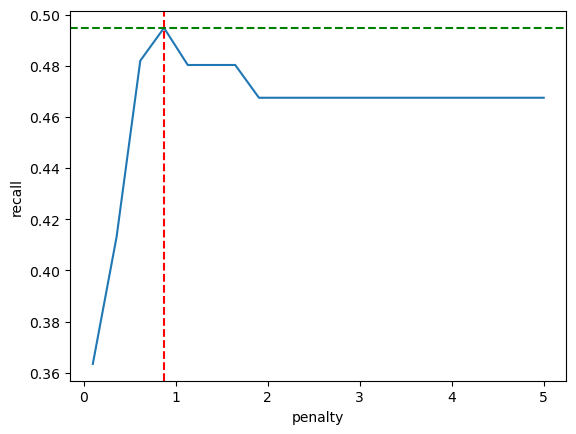

In [373]:
graph_optim()

Le degré de pénalité optimum est donc 0.873

In [374]:
# On prendra la sélection correspondant à cette valeur de l'hyperparamètre
sel_ = SelectFromModel(LogisticRegression(C=0.873, penalty='l1',solver='liblinear',random_state=42))

sel_.fit(scaler.transform(x_train), y_train) # entraîner le modèle pour la sélection des variables
selection=x_train.columns[sel_.get_support()]
selection

Index(['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'RETAILx', 'IPDCONGD', 'IPNCONGD',
       'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPB51222S', 'IPFUELS', 'HWI',
       'HWIURATIO', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26',
       'CES1021000001', 'USCONS', 'NDMANEMP', 'SRVPRD', 'USWTRADE', 'USTRADE',
       'USFIRE', 'CES0600000007', 'AWOTMAN', 'HOUST', 'HOUSTMW', 'PERMITS',
       'PERMITW', 'AMDMNOx', 'AMDMUOx', 'BUSINVx', 'ISRATIOx', 'M2SL',
       'M2REAL', 'BOGMBASE', 'BUSLOANS', 'REALLN', 'NONREVSL', 'CONSPI',
       'S&P 500', 'S&P div yield', 'FEDFUNDS', 'TB3MS', 'BAA', 'COMPAPFFx',
       'TB3SMFFM', 'BAAFFM', 'EXJPUSx', 'EXUSUKx', 'EXCAUSx', 'WPSFD49502',
       'WPSID61', 'WPSID62', 'PPICMM', 'CPIAUCSL', 'CPITRNSL', 'CUSR0000SAD',
       'CUSR0000SAS', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA', 'CES2000000008',
       'CES3000000008', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'VIXCLSx'],
      dtype='object')

In [528]:
len(selection)

69

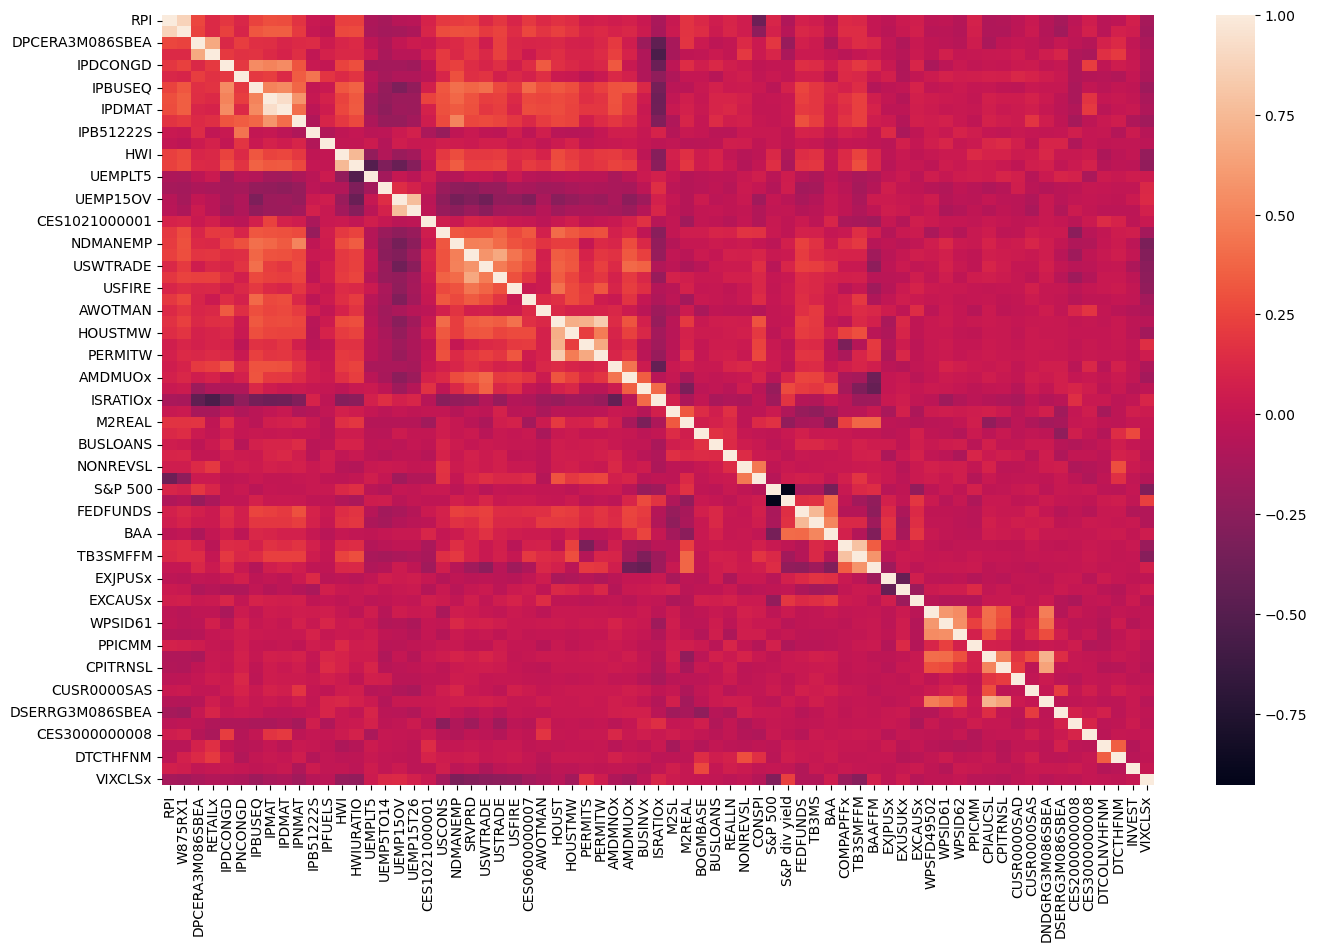

In [375]:
# matrice de corrélation
plt.figure(figsize = (16,10))

ax = sns.heatmap(x_train[selection].corr())

Une matrice peu corrélée après la sélection par le lasso : on n'a pas de problème de multicolinéarité

In [377]:
# les corrélation en dessus de 0.7 
s=x_train[selection].corr().unstack().sort_values(ascending=False).drop_duplicates()
s.where(s>0.7).dropna()  # la seule forte corrélation est entre IPMAT et IPDMAT

RPI        RPI                1.000000
IPMAT      IPDMAT             0.929638
W875RX1    RPI                0.876484
PERMITW    HOUST              0.840959
COMPAPFFx  TB3SMFFM           0.789768
UEMP15T26  UEMP15OV           0.773740
FEDFUNDS   TB3MS              0.750130
HWIURATIO  HWI                0.748232
CPIAUCSL   DNDGRG3M086SBEA    0.717833
PERMITS    HOUST              0.706599
dtype: float64

In [385]:
# corrélation point bisserial : corrélation des variables sélectionnées avec le target
lst=[]
for i in x_train[selection].columns:
    tup=stats.pointbiserialr(y_train, x_train[i])
    lst.append(tup)
    
cor=pd.DataFrame(lst)
cor.index=x_train[selection].columns
s_cor=cor['correlation'].abs().sort_values(ascending=False) # les corrélations avec la target ( en valeur absolue )
s_cor

TB3SMFFM         0.485665
HWIURATIO        0.424176
HOUST            0.403478
CES0600000007    0.379505
NDMANEMP         0.377980
                   ...   
WPSFD49502       0.007476
CES3000000008    0.004834
WPSID61          0.003167
BOGMBASE         0.002489
CPITRNSL         0.001094
Name: correlation, Length: 69, dtype: float64

In [530]:
s_cor.to_csv('corrtarget.csv')

In [399]:
# on droppe les variables présentant une corrélation < = à 10% . 
faible_cor=s_cor.where(s_cor<=0.1).dropna().index
faible_cor

Index(['CONSPI', 'IPNCONGD', 'BUSINVx', 'M2SL', 'CES1021000001', 'EXJPUSx',
       'IPB51222S', 'REALLN', 'CUSR0000SAS', 'INVEST', 'DSERRG3M086SBEA',
       'DTCTHFNM', 'IPFUELS', 'WPSID62', 'EXCAUSx', 'NONREVSL', 'BUSLOANS',
       'CES2000000008', 'DTCOLNVHFNM', 'DNDGRG3M086SBEA', 'EXUSUKx', 'PPICMM',
       'CUSR0000SAD', 'CPIAUCSL', 'WPSFD49502', 'CES3000000008', 'WPSID61',
       'BOGMBASE', 'CPITRNSL'],
      dtype='object')

In [400]:
x_train1=x_train[selection].drop(faible_cor,axis=1)   # dropper la liste des variables faible_cor
y_train1=y_train.replace(to_replace={0:'recess',1:'no recess'})

df_train=pd.concat([x_train1,y_train1],axis=1)

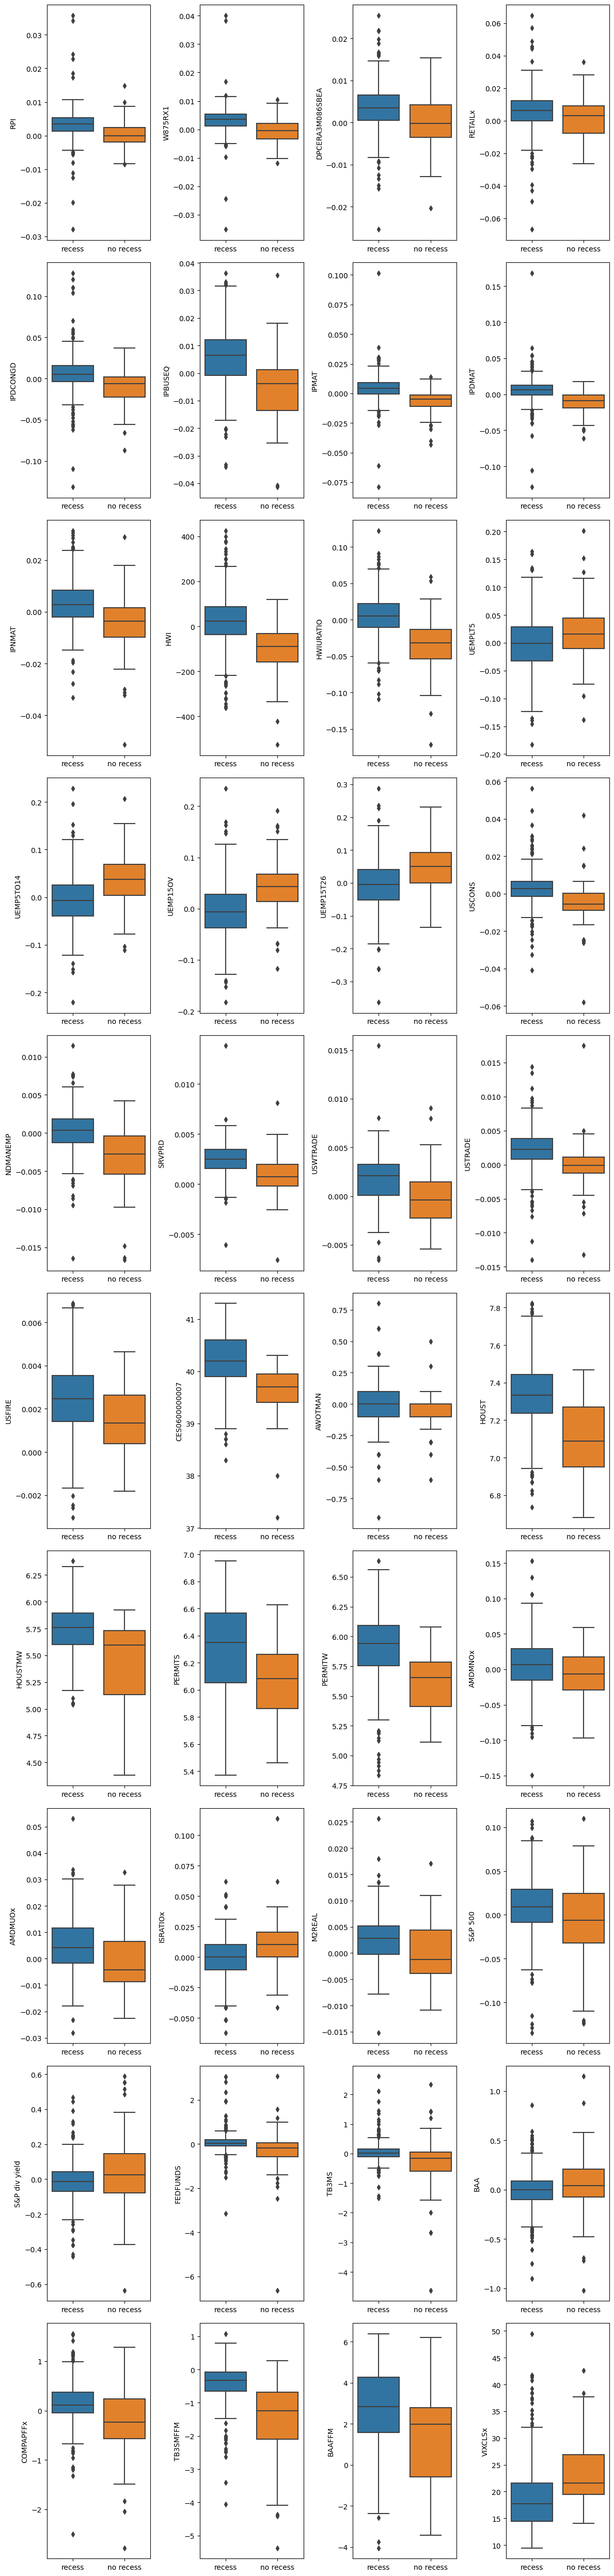

In [402]:
# Boxplots
figure, axes = plt.subplots(10,4, sharex=False, figsize=(12,50))


def remplir_plots(ligne,num_var):
    for i,j in enumerate(x_train1.columns[num_var-4:num_var]):
            plot=sns.boxplot(ax=axes[ligne,i],data=df_train,x='usrec',y=j)
            plot.set(xlabel=None)
            plt.tight_layout()
k1=0
k2=4
while k2<=40:
    remplir_plots(k1,k2)
    k1=k1+1
    k2=k2+4


Les variables explicatives montrent plus ou moins des boxplots différencants. La visualisation des distribution des variables pour chaque régime ( recession et no recession ) est fondamentale pour juger de son importance pour la target.

### Degré d'équilibre de la target

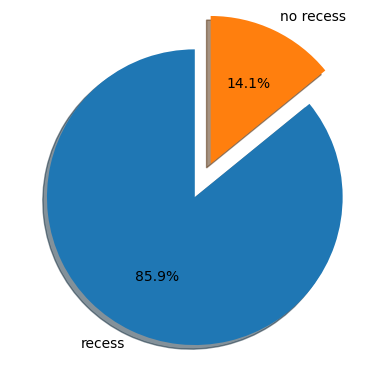

In [403]:
s=df_train['usrec'].value_counts()/df_train['usrec'].shape[0]*100  # série de 2 valeurs : % de la classe 1 et % de la classe 2
labels = s.index[0],s.index[1]
sizes = [s.iloc[0],s.iloc[1]]
explode = (0, 0.25)  # exploser la 2ème tranche (recession)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

Data déséquilibrée : 14% des observations seulement sont des récessions. Ce résultat est attendu car les récessions sont rares. Il est important de prendre cela en compte dans l'évaluation de la performance des modèles, car l'accuracy ici sera un metric trompeur. 

### Modèles de ML, évaluation et tuning des hyperparamètres

Nous allons d'abord commencer par tester les modèles, en utilisant les valeurs par défaut des hyperparamètres. Dans un second temps, nous procèderons au tuning des prinicpaux hyperparamètres pour chaque modèle par cross validation, puis nous testerons les modèles sur l'échantillon test avec les hyperparamètres optimums.

In [404]:
# D'abord, appliquer les mêmes transformations à l'échantillon test : voir si il y a des NaNs, éliminer les variables supprimées
# dans l'échantillon d'entraînement ,stationnariser les variables gardées et lagger les variables de 2 mois par rapport à la target.
df_test.isnull().sum().sort_values(ascending=False)

COMPAPFFx        1
CP3Mx            1
RPI              0
TB6MS            0
AAAFFM           0
                ..
DMANEMP          0
MANEMP           0
USCONS           0
CES1021000001    0
VIXCLSx          0
Length: 123, dtype: int64

In [405]:
# on remplace les 2 valeurs NaNs des 2 variables 'COMPAPFFx' et 'CP3Mx' par les moyennes (sur l'échantillon test, il ne faut
# emprunter aucune info de l'échantillon d'entraînement )
df_test1=df_test.fillna(df_test.mean())
df_test2=df_test1[x_train1.columns]    # ne prendre que les features gardés dans l'échantillon d'entraînement

In [406]:
# stationnariser les variables de l'échantillon test
lst=[]
lst_codes=df[x_train1.columns].iloc[0]
for i,code in enumerate(lst_codes):
    lst.append(transf(df_test2[df_test2.columns[i]],code))   

new_lst=[col['2003-12-01':] for col in lst]  # car il y a des double différenciations pour ne pas avoir des NaNs
x_test=pd.concat(new_lst,axis=1)
y_test=recess['2003-12-01':'2022-09-01']  # ajuster la période du x_test sur la période du x_test puisqu'il y a le décalage 
                                         # des doubles différenciations

In [425]:
# lagger les variables explicatives de 2 mois
x_test1=x_test.shift(2).dropna()
y_test1=y_test['2004-02-01':]

### Régression logistique avec hyperparamètres de défaut

In [428]:
from warnings import filterwarnings
filterwarnings('ignore')                # ces 2 lignes servent juste à annuler le warning de sklearn
# Régression logistique:
logreg = LogisticRegression()   
logreg.fit(x_train1, y_train)  
y_pred = logreg.predict(x_test1)   
print("Accuracy={:.2f}".format(logreg.score(x_test1, y_test1)))

Accuracy=0.94


In [430]:
#L'accuracy ici n'est pas le bon metric du au déséquilibre de la data
# on utilise la confusion matrix : Regardons commbien de périodes de récessions ont été bien prédites
confusion_matrix=pd.crosstab(y_test1,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted  0.0  1.0
Actual             
0.0        199    5
1.0          8   12


12 périodes de récessions sur 20 on été correctement prédites soit un recall de 60% , largement loin de l'accuracy trompeuse.

### KNN avec hyperparamètres de défaut

In [432]:
# d'abord scaler nos variables
scaler=StandardScaler()
scaler.fit(x_train1)

# appliquer le modèle
knn = KNeighborsClassifier()
knn=knn.fit(scaler.transform(x_train1),y_train)
y_pred = knn.predict(scaler.transform(x_test1))  
knn.score(scaler.transform(x_test1),y_test1)

0.9553571428571429

In [433]:
confusion_matrix=pd.crosstab(y_test1,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted  0.0  1.0
Actual             
0.0        201    3
1.0          7   13


### Random Forest avec hyperparamètres de défaut

In [442]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train1,y_train)

y_pred = rfc.predict(x_test1)
rfc.score(x_test1,y_test1)

0.9598214285714286

In [443]:
confusion_matrix=pd.crosstab(y_test1,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted  0.0  1.0
Actual             
0.0        201    3
1.0          6   14


## Tuning des hyperparamètres

### KNN : l'hyperparamètre est le nombre de voisins

In [439]:
# Vu qu'on travaille sur une série temporelle , la cross validation standard n'est pas valable. Il existe une fonction 
# timeseriessplit qui permet de remédier à cela 
from sklearn.model_selection import cross_val_score
n = [i for i in range(1,50)]  # Nbre de voisins
kfold = model_selection.TimeSeriesSplit(n_splits=3)   # cross validation avec time series split 
def cross_val(metric):
    ''' retourne une série des valeurs du metric choisi pour chaque valeur de l'hyperparamètre'''
    scores_lst = []
    for i in n:
        knn = KNeighborsClassifier(n_neighbors=i)
        scores = cross_val_score(knn,scaler.transform(x_train1),y_train,scoring=metric, cv=kfold) # cross validation
        scores_lst.append(scores.mean())
    sc=pd.Series(data=scores_lst,index=n)
    return sc

In [440]:
def graph_optim(metric):
    fig=sns.lineplot(x=n,y=cross_val(metric))
    max_metric=cross_val(metric).max()
    max_metric_n=cross_val(metric).idxmax()
    fig.axvline(x=max_metric_n,linestyle='--',color='red')
    fig.axhline(y=max_metric,linestyle='--',color='green')
    plt.xlabel('n_voisins')
    plt.ylabel(metric)

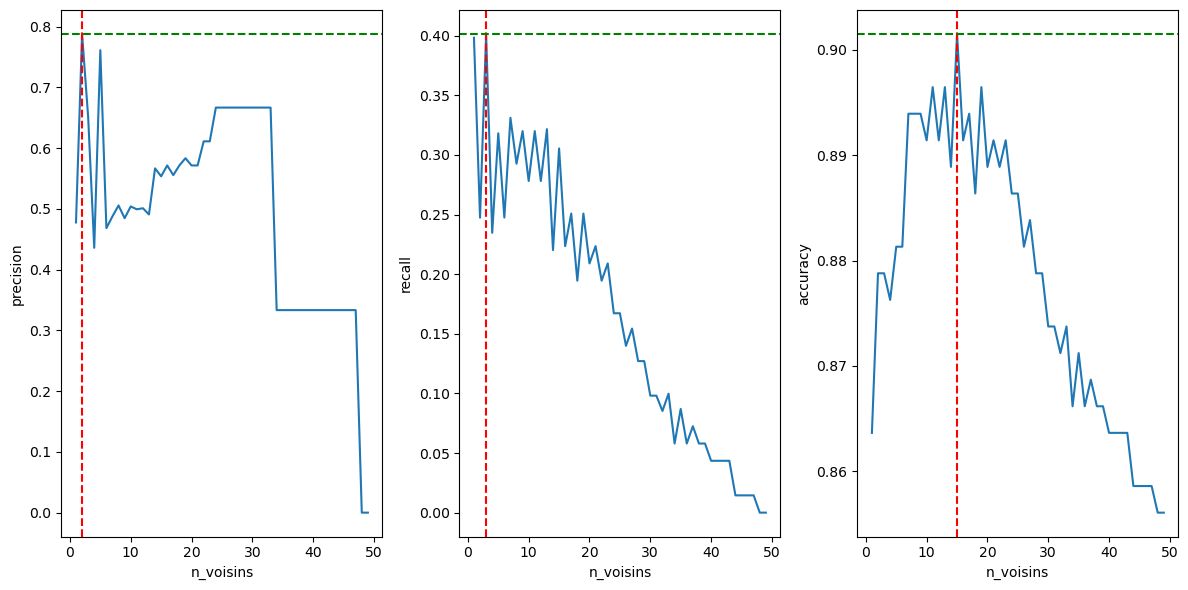

In [441]:
plt.figure(figsize=(12,6))
plt.title("Optimisation du n_voisins par cross validation")
plt.subplot(1,3,1)
graph_optim('precision')
plt.subplot(1,3,2)
graph_optim('recall')
plt.subplot(1,3,3)
graph_optim('accuracy')
plt.tight_layout()
plt.show()

Ces 3 plots montrent clairement que c'est le recall qui révèle la vraie performance du modèle : la précision et l'accuracy 
sont trompeurs du au déséquilibre de la data. Le nombre de récessions étant faible, le modèle aurait une très bonne performance même si il ne prédit aucun récession. Alors que le but de ce projet est de prédire les récessions. 

In [444]:
# le nombre de voisins optimum selon le recall est 3 . essayons le KNN avec cette valeur de l'hyperparamètre

In [446]:
knn = KNeighborsClassifier(n_neighbors=3)
knn=knn.fit(scaler.transform(x_train1),y_train)
y_pred = knn.predict(scaler.transform(x_test1))  
knn.score(scaler.transform(x_test1),y_test1)

0.9508928571428571

In [447]:
confusion_matrix=pd.crosstab(y_test1,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted  0.0  1.0
Actual             
0.0        199    5
1.0          6   14


Le recall a très légèrement augmenté de 13/20 récessions correctes à 14/20 soit 70%.

### Random Forest : Les (principaux) hyperparamètres sont n_features et n_arbres

In [451]:
# Ici , on a 2 boucles imbriqués car on veut optimiser un couple d'hyperparamètres

n_features = [x for x in range(1,39)]  # nombre de features est inf au nbre total de features (40). 
n_estimators=[x for x in range(1,100)]
cv_scores={}
for f in n_features:
    for e in n_estimators:
        rfc = RandomForestClassifier(n_estimators=e,max_features=f,random_state=42)
        scores = cross_val_score(rfc,x_train1, y_train, cv=kfold,scoring='recall') 
        cv_scores[(e,f)]=scores.mean()      

In [452]:
max(cv_scores,key=cv_scores.get)   # le nbre d'arbres optimum est 1 et le nbre de features optimum est 13 
                                   # c'est semblable à l'arbre de décision sauf que le nombre de features n'est pas le nombre
                                   # total.

(1, 13)

In [457]:
cv_scores[(1,13)]   # le recall (cross-validé) de cette combinaison est de 72% 

0.7159977703455964

In [465]:
rfc = RandomForestClassifier(n_estimators=1,max_features=13,random_state=42)
rfc.fit(x_train1,y_train)

y_pred = rfc.predict(x_test1)
rfc.score(x_test1,y_test1)

0.9241071428571429

In [466]:
confusion_matrix=pd.crosstab(y_test1,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

Predicted  0.0  1.0
Actual             
0.0        199    5
1.0         12    8


Out-of-sample , le modèle a mal performé avec les hyperparamètres déterminés par cross validation
Le recall est de 40% (8/20) : en dessous de la moyenne

### Rotation Forest : Tuning des hyperparamètres (nombre d'arbres,nombres de features par subset)

In [468]:
pip install rotation-forest

Note: you may need to restart the kernel to use updated packages.Collecting rotation-forest
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rotation-forest: filename=rotation_forest-1.0-py3-none-any.whl size=6988 sha256=45a15395e766111464e4178484c869b1c2ff7c5e7796ce3d0420f761baeecdd4
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\04\28\af\19c7cfcb128fc97ffbeba385ead0bc94a431f1154b25f59699
Successfully built rotation-forest



In [524]:
from rotation_forest import RotationForestClassifier
n_features_per_subset = [x for x in range(5,11)]  
n_estimators=[x for x in range(1,50)]
cv_scores={}
for f in n_features_per_subset:
    for e in n_estimators:
        rf = RotationForestClassifier(n_estimators=e,n_features_per_subset=f,random_state=42) 
        scores = cross_val_score(rf,x_train1, y_train, cv=kfold,scoring='recall') 
        cv_scores[(e,f)]=scores.mean()      

In [525]:
max(cv_scores,key=cv_scores.get)  

(9, 8)

In [526]:
# 9 arbres et 8 features par subset ( ca veut dire 5 sous-vecteurs de features : l'hyperparamètre dont on a parlé dans le 
# rapport ). Cette combinaison d'hyperparamètres est la combinaison optimale, par cross valid

In [527]:
# évaluer le modèle
rf=RotationForestClassifier(n_estimators=9,n_features_per_subset=8)    
rf.fit(x_train1,y_train)
y_pred = rf.predict(x_test1)
# accuracy
print('accuracy:',rf.score(x_test1,y_test1))
# confusion matrix
confusion_matrix=pd.crosstab(y_test1,y_pred,rownames=['Actual'],colnames=['Predicted'])
print(confusion_matrix)

accuracy: 0.7723214285714286
Predicted  0.0  1.0
Actual             
0.0        158   46
1.0          5   15
